# Coursera IBM Data Science Capstone Project
## Where to open an Indian restaurant in Ireland?  


By Tamela Maciel, June 2020

This jupyter notebook completes Coursera's IBM Data Science Professional Certificate capstone project.

It uses the Foursquare API, BeautifulSoup for webscraping, and various python libraries to gather location data.

### Import libraries

In [282]:
import pandas as pd  #database wrangling
import numpy as np #linear algebra
#import string
from bs4 import BeautifulSoup #webscraping

from pandas import json_normalize # tranform JSON file into a pandas dataframe

import requests # library to handle requests

#geolocation
from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
#import matplotlib.cm as cm
#import matplotlib.colors as colors

# import k-means from clustering stage
#from sklearn.cluster import KMeans

import folium # map rendering library

### Largest Irish cities by population

According to the [2011 UK census](https://en.wikipedia.org/wiki/List_of_urban_areas_in_the_United_Kingdom), Leicester is the 13th largest built-up area in the UK, and so in order to match the client's criteria of a similarly large urban location, we will analyse and profile the 13 largest urban areas in Ireland in order to determine the best new Indian restaurant location.

This population data can be scraped from the [Wikipedia table: List of urban areas in the Republic of Ireland by population](https://en.wikipedia.org/wiki/List_of_urban_areas_in_the_Republic_of_Ireland_by_population), drawn from the 2016 Irish census. 

We use BeautifulSoup to get the data in this table, cleaning and type converting the data as we go:

In [265]:
#Request html from the website url:

url = 'https://en.wikipedia.org/wiki/List_of_urban_areas_in_the_Republic_of_Ireland_by_population'
response = requests.get(url)
soup = BeautifulSoup(response.text)

# Find the first table in the html items:
table = soup.find('table')

In [311]:
#create empty dataframe 'cities_df'
column_names=['city','county','population']
cities_df = pd.DataFrame(columns=column_names) 

#read in data for top 13 cities using table and get_text() functions from Beautiful Soup
row_id = 0
for row in table.find_all('tr'):
    columns = row.find_all('td')
    if len(columns)>0:
        rank=int(columns[0].get_text())
        city=columns[2].get_text().split('[')[0] #the split is necessary because text ends with superscript '[a]' in many cases
        county=columns[3].get_text()
        population=int(columns[4].get_text().split('[')[0].replace(',', '')) #first split out [a], select number, then remove commas before casting to integer
        if rank < 14:
            cities_df = cities_df.append({'city': city,
                                                      'county':county,
                                                      'population': population
                                                     }, ignore_index=True)
        else: break
    else:
        pass
    row_id += 1

cities_df

,city,county,population
0,Dublin,County Dublin,1173179
1,Cork,County Cork,208669
2,Limerick,County Limerick & County Clare,94192
3,Galway,County Galway,79934
4,Waterford,County Waterford & County Kilkenny,53504
5,Drogheda,County Louth & County Meath,40956
6,Swords,Fingal,39248
7,Dundalk,County Louth,39004
8,Bray,County Wicklow & County Dublin,32600
9,Navan,County Meath,30173


Now we have the 13 largest Irish cities that we will profile by their restaurants and demographics in order to recommend the best places for a new Indian restaurant.

### Get latitude and longitude for each city

We'll use geopy to get lat, long coordinates for each city.

In [334]:
#set up geolocator and define function to get lat,long
geolocator = Nominatim(user_agent="coursera")
def get_coordinates(city):
    '''get town lat, long:'''
    #on inspection, 'carlow' returns the lat,long of the county so need to add 'carlow town' just for this one
    if city=='Carlow':
        location = geolocator.geocode(city+' town, Ireland')
    else:
        location = geolocator.geocode(city+', Ireland')
    lat=location.latitude
    lon=location.longitude
    return [lat,lon]

#test with city
city='Carlow'
lat,lon=get_coordinates(city)
print('The coordinates of {} are {},{}'.format(city,lat,lon))

The coordinates of Carlow are 52.8408344,-6.9261131


In [335]:
#get list of coordinates for each city
coords=df['city'].apply(get_coordinates).tolist()
coords

[[53.3497645, -6.2602732],
 [51.8979282, -8.4705806],
 [52.661252, -8.6301239],
 [53.2744122, -9.0490632],
 [52.2609997, -7.1119081],
 [53.7149877, -6.3524183],
 [53.4598264, -6.2184562],
 [54.0046033, -6.4008879],
 [53.2014604, -6.1105049],
 [53.651908, -6.6833615],
 [52.6510216, -7.2484948],
 [52.8435152, -8.983747],
 [52.8408344, -6.9261131]]

In [336]:
#append lat and long to df
cities_df['lat']=[coord[0] for coord in coords]
cities_df['long']=[coord[1] for coord in coords]
cities_df

,city,county,population,lat,long
0,Dublin,County Dublin,1173179,53.349764,-6.260273
1,Cork,County Cork,208669,51.897928,-8.470581
2,Limerick,County Limerick & County Clare,94192,52.661252,-8.630124
3,Galway,County Galway,79934,53.274412,-9.049063
4,Waterford,County Waterford & County Kilkenny,53504,52.261000,-7.111908
5,Drogheda,County Louth & County Meath,40956,53.714988,-6.352418
6,Swords,Fingal,39248,53.459826,-6.218456
7,Dundalk,County Louth,39004,54.004603,-6.400888
8,Bray,County Wicklow & County Dublin,32600,53.201460,-6.110505
9,Navan,County Meath,30173,53.651908,-6.683362


Let's look at these city coordinates on a map to make sure our lat,longs are accurate.


In [348]:
ireland_centre=(53.5,-8.0) #the geographic centre of Ireland is near Athlone
map_cities = folium.Map(location=ireland_centre, zoom_start=7)

for lat, lon, city in zip(cities_df['lat'],cities_df['long'],cities_df['city']):
    #folium.CircleMarker([lat, lon], radius=2, color='#d21c04', fill=True, fill_color='blue', fill_opacity=1).add_to(map_cities) 
    folium.Circle([lat, lon], radius=1500, color='#d21c04', fill=True,fill_colour='#d21c04',fill_opacity=0.4).add_to(map_cities)

map_cities.save('report/images/all_cities_map.html') 
map_cities

On inspection, the coordinates for each city seems to be correct and well-centred on the urban area. The radius of the circle is set to 1500 metres, which seems to give good coverage of the city centre area, even for Dublin.

This will be the search radius we use for the Foursquare API.

### Ethnicity of Irish residents

In [154]:
ethnic_df = pd.read_csv("data/all_ethnicities_ireland_2016.csv",header=None)
ethnic_df

,0,1,2,3,4
0,State,Both sexes,All ages,White Irish,3854226
1,State,Both sexes,All ages,White Irish Traveller,30987
2,State,Both sexes,All ages,Any other White background,446727
3,State,Both sexes,All ages,Black or Black Irish - African,57850
4,State,Both sexes,All ages,Black or Black Irish - any other Black background,6789
5,State,Both sexes,All ages,Asian or Asian Irish - Chinese,19447
6,State,Both sexes,All ages,Asian or Asian Irish - any other Asian background,79273
7,State,Both sexes,All ages,Other including mixed background,70603
8,State,Both sexes,All ages,Not stated,124019


In [155]:
# clean up the dataset to remove first three unnecessary columns 
ethnic_df=ethnic_df.drop([0,1,2], axis=1)
ethnic_df

,3,4
0,White Irish,3854226
1,White Irish Traveller,30987
2,Any other White background,446727
3,Black or Black Irish - African,57850
4,Black or Black Irish - any other Black background,6789
5,Asian or Asian Irish - Chinese,19447
6,Asian or Asian Irish - any other Asian background,79273
7,Other including mixed background,70603
8,Not stated,124019


In [156]:
# rename columns
ethnic_df.columns=['ethnicity','2016 population']
ethnic_df

,ethnicity,2016 population
0,White Irish,3854226
1,White Irish Traveller,30987
2,Any other White background,446727
3,Black or Black Irish - African,57850
4,Black or Black Irish - any other Black background,6789
5,Asian or Asian Irish - Chinese,19447
6,Asian or Asian Irish - any other Asian background,79273
7,Other including mixed background,70603
8,Not stated,124019


In [150]:
ethnic_df.dtypes

ethnicity          object
2016 population     int64
dtype: object

In [171]:
total=sum(ethnic_df['2016 population'])
print("Total Irish population in 2016 is {} people".format(total))

def percentage(pop):
    x=(pop/total)*100
    return x

ethnic_df['percentage']=ethnic_df[['2016 population']].apply(percentage)

ethnic_df=ethnic_df.sort_values(by=['2016 population'], ascending=True)
ethnic_df

Total Irish population in 2016 is 4689921 people


,ethnicity,2016 population,percentage
4,Black or Black Irish - any other Black background,6789,0.144757
5,Asian or Asian Irish - Chinese,19447,0.414655
1,White Irish Traveller,30987,0.660715
3,Black or Black Irish - African,57850,1.233496
7,Other including mixed background,70603,1.505420
6,Asian or Asian Irish - any other Asian background,79273,1.690284
8,Not stated,124019,2.644373
2,Any other White background,446727,9.525256
0,White Irish,3854226,82.181043


<Figure size 460.8x316.8 with 0 Axes>

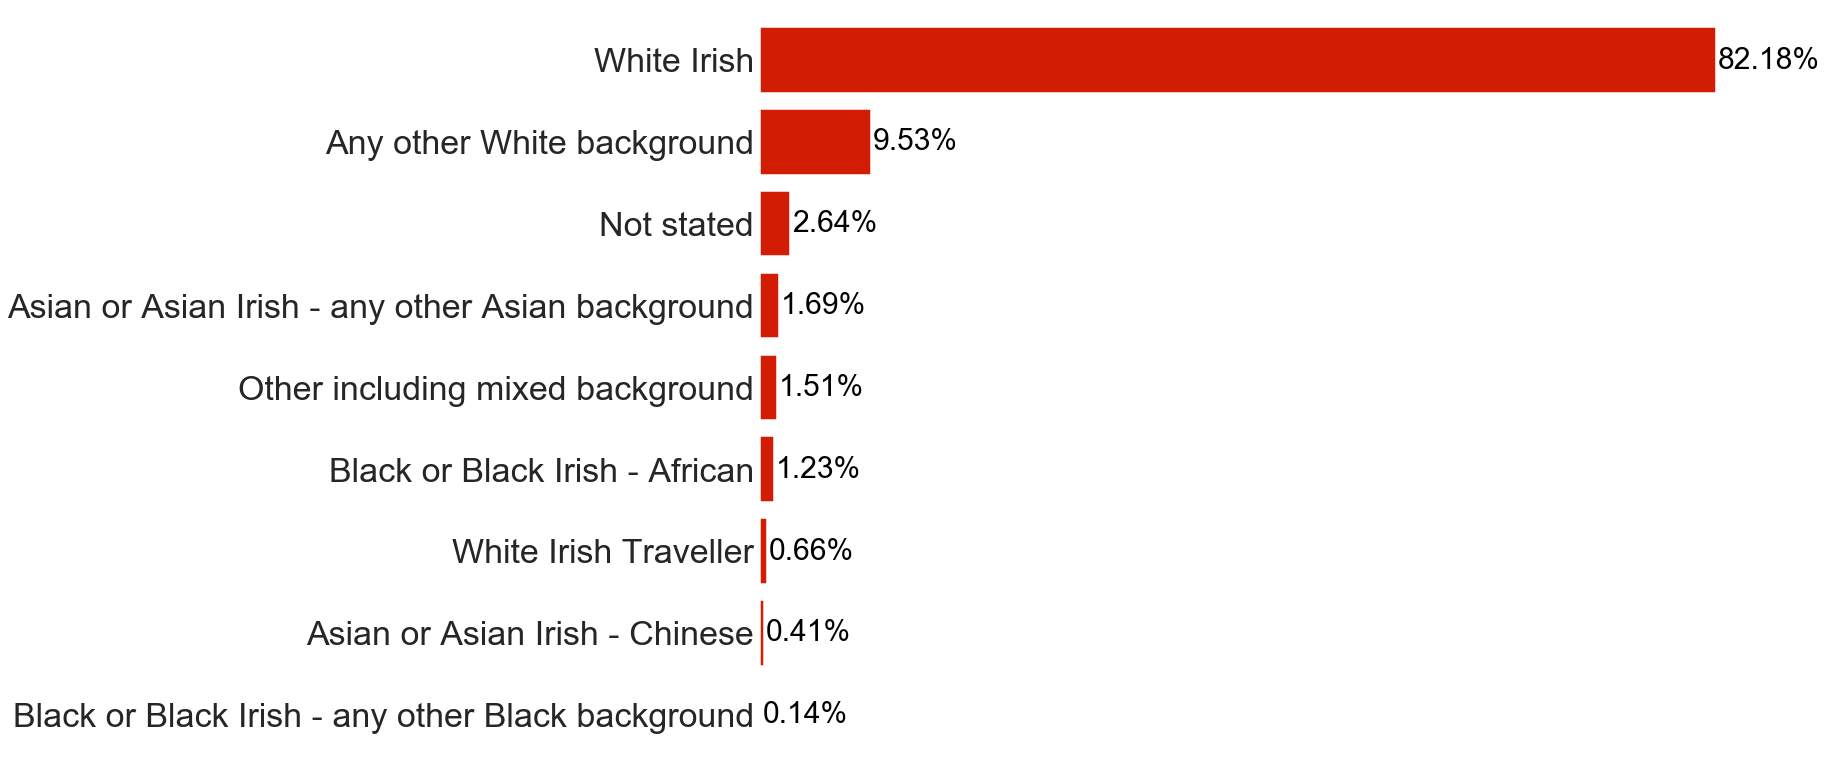

In [220]:
# plot ethnicity percentage
plt.clf()

mpl.style.use('seaborn-white')

ax = ethnic_df.plot(y='percentage',x='ethnicity',kind='barh',color='#d21c04',figsize=(18,14),width=0.8,legend=False,fontsize=34) 
#ax.set_title("Irish residents by ethnic or cultural background")
#plt.xlabel('Percentage of 2016 Irish population',fontsize=30) 
plt.ylabel('')

#remove left,right, top spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#remove x ticks
ax.get_xaxis().set_ticks([])
    
#label bar values
for index, value in enumerate(ethnic_df['percentage']): 
    label = "{:0.2f}%".format(value) 
    # place text at the end of bar (add small amounts to offset and centre the labels)
    plt.annotate(label, xy=(value+0.15, index-0.10), color='black',fontsize=30)

# save plot
plt.savefig("report/images/irish_ethnicity.png",dpi=300,bbox_inches='tight') #bbox_inches=tight prevents the image being cutoff during save

plt.show()

### Ethnicity of Irish residents by county

In [239]:
asian_by_county = pd.read_csv("data/asian_irish_counties_2016.csv",header=None)
# clean up the dataset to remove first three unnecessary columns 
asian_by_county=asian_by_county.drop([0,1,2], axis=1)
# rename columns
asian_by_county.columns=['county','asian-other population']

#sort
asian_by_county=asian_by_county.sort_values(by=['asian-other population'], ascending=True)

asian_by_county.tail()

,county,asian-other population
17,Cork County,3681
2,Dun Laoghaire-Rathdown,5630
4,South Dublin,9244
3,Fingal,9355
1,Dublin City,15606


<Figure size 460.8x316.8 with 0 Axes>

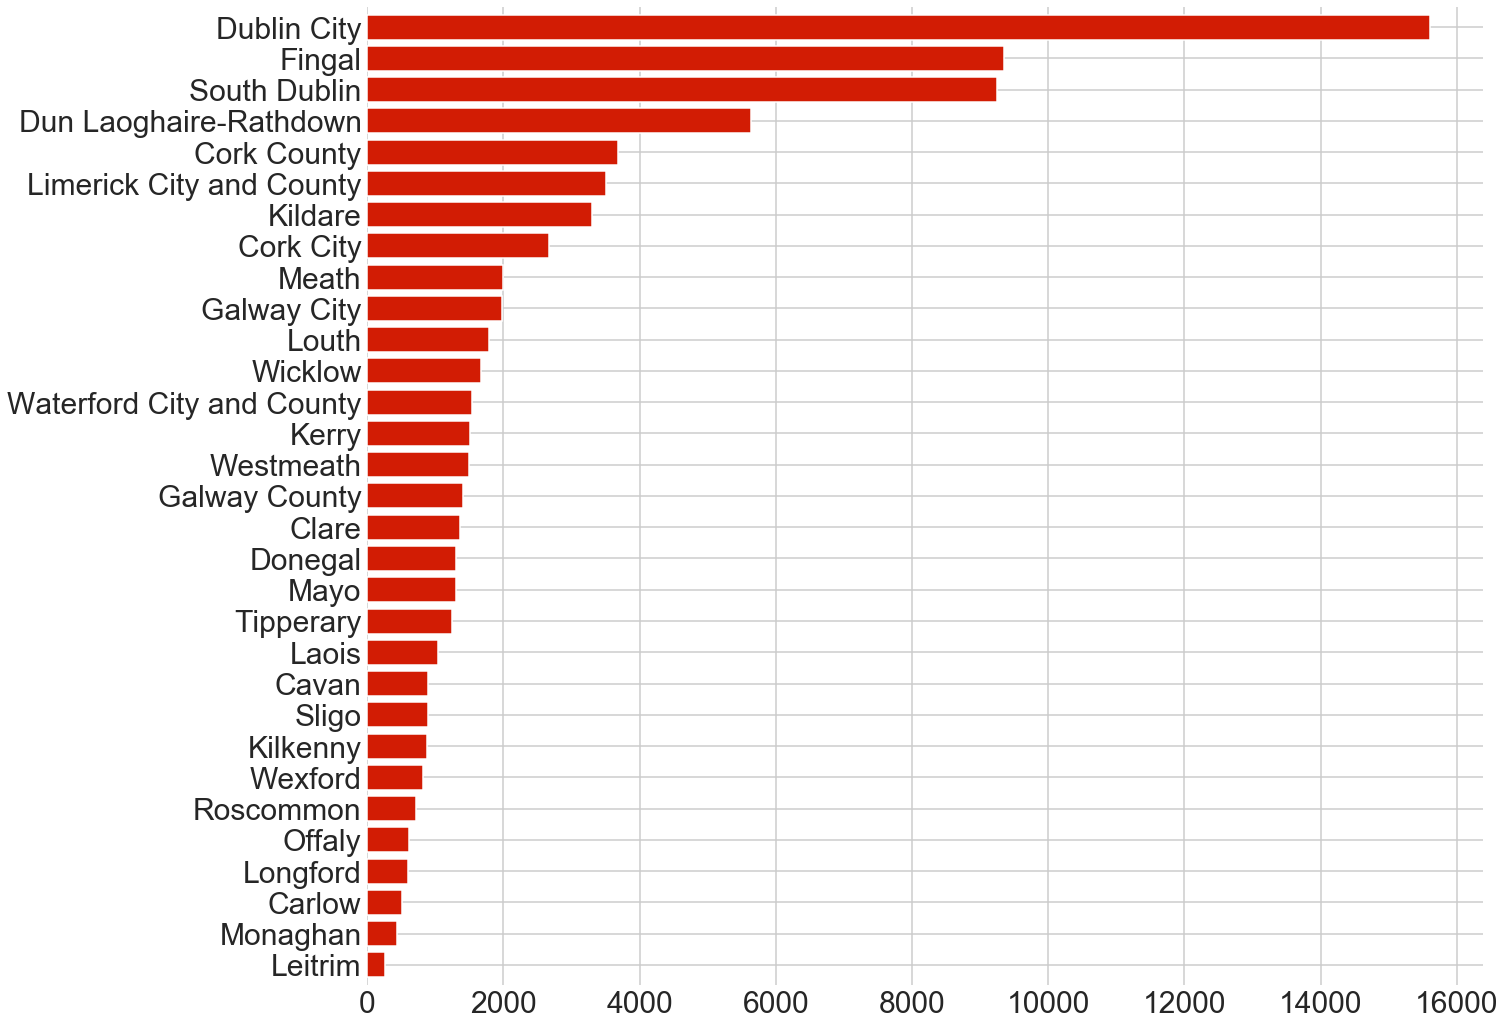

In [249]:
# plot counties by asian ethnicity
plt.clf()
#
mpl.style.use('seaborn-whitegrid')

ax = asian_by_county.plot(y='asian-other population',x='county',kind='barh',color='#d21c04',width=0.8,legend=False,figsize=(20,18),fontsize=30) 
plt.ylabel('')

#remove left,right, top spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
    

# save plot
plt.savefig("report/images/counties_asian_ethnicity.png",dpi=300,bbox_inches='tight') #bbox_inches=tight prevents the image being cutoff during save

plt.show()

### Get venues for each city using the Foursquare API

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [32]:
CLIENT_ID = 'LRZS1Q1R12WGF52OQPOSHLS4CC3NNRZYTSKECAHUTTYW0TMR' # your Foursquare ID
CLIENT_SECRET = 'SYHT1RYKRHP5VV3ARJC01GTXMM0ERHOLZXGPL4TYGOPHS1PB' # your Foursquare Secret
VERSION = '20200601' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: LRZS1Q1R12WGF52OQPOSHLS4CC3NNRZYTSKECAHUTTYW0TMR
CLIENT_SECRET:SYHT1RYKRHP5VV3ARJC01GTXMM0ERHOLZXGPL4TYGOPHS1PB


In [41]:
# return up to 100 restaurants within 1km radius of lat,long. For Leicester this is 90 restaurants.

city = 'Leicester'
lat =52.633331
long = -1.133333
query='restaurant'
radius = 1000
limit = 100

In [42]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    long, 
    query,
    radius, 
    limit)
results = requests.get(url).json()

'https://api.foursquare.com/v2/venues/explore?&client_id=LRZS1Q1R12WGF52OQPOSHLS4CC3NNRZYTSKECAHUTTYW0TMR&client_secret=SYHT1RYKRHP5VV3ARJC01GTXMM0ERHOLZXGPL4TYGOPHS1PB&v=20200601&ll=52.633331,-1.133333&query=restaurant&radius=1000&limit=100'

In [50]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Peter Pizzeria,Pizza Place,52.631894,-1.133741
1,PizzaExpress,Pizza Place,52.631663,-1.132414
2,Pret A Manger,Sandwich Place,52.635455,-1.132535
3,Pieros Snack Bar,Restaurant,52.634606,-1.135849
4,The White Peacock,Restaurant,52.631138,-1.132235
5,Nando's,Portuguese Restaurant,52.633401,-1.129511
6,Knight & Garter,Gastropub,52.633913,-1.134372
7,Bombay Bites,Indian Restaurant,52.632547,-1.131534
8,Bill's Restaurant,English Restaurant,52.635839,-1.137399
9,Crafty Burger @ St Martin's,Burger Joint,52.634770,-1.134822


In [117]:
# Try for Dublin

city = 'Dublin'
lat =53.349804
long = -6.260310
#query='indian restaurant'
section='food'
#categoryId='4d4b7105d754a06374d81259'
radius = 1500
limit = 100
#offset=100
pop=1

In [118]:
# get venues
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section={}&radius={}&limit={}&sortByPopularity={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    long, 
    section,
    radius,
    limit,
    pop)
results = requests.get(url).json()


In [119]:
venues = results['response']['groups'][0]['items']
    
dublin_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
dublin_venues =dublin_venues.loc[:, filtered_columns]

# filter the category for each row
dublin_venues['venue.categories'] = dublin_venues.apply(get_category_type, axis=1)

# clean columns
dublin_venues.columns = [col.split(".")[-1] for col in dublin_venues.columns]

dublin_venues

,name,categories,lat,lng
0,The Brazen Head,Irish Pub,53.344982,-6.276335
1,Brother Hubbard North,Café,53.347137,-6.268377
2,Bread 41,Bakery,53.344812,-6.251619
3,Bunsen,Burger Joint,53.341178,-6.260037
4,Eddie Rocket's,Diner,53.347805,-6.259827
...,...,...,...,...
95,Toffoli,Café,53.343301,-6.269331
96,Bel Cibo,Pizza Place,53.348569,-6.278632
97,Tommy O'Gara's Pub,Irish Pub,53.350993,-6.282447
98,The Sideline Bistro,Restaurant,53.360659,-6.254021


In [120]:
dublin_venues[dublin_venues['categories']=='Indian Restaurant']

,name,categories,lat,lng
81,Ruposhi Indian Restaurant,Indian Restaurant,53.361904,-6.260117
93,Spice n Rice,Indian Restaurant,53.359425,-6.261525


In [121]:
# Try for Cork

city = 'Cork'
lat =51.897869
long = -8.471090
#query='indian restaurant'
section='food'
#categoryId='4d4b7105d754a06374d81259'
radius = 1500
limit = 100
#offset=100
pop=1

In [122]:
# get venues
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section={}&radius={}&limit={}&sortByPopularity={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    long, 
    section,
    radius,
    limit,
    pop)
results = requests.get(url).json()


In [123]:
venues = results['response']['groups'][0]['items']
    
cork_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
cork_venues =cork_venues.loc[:, filtered_columns]

# filter the category for each row
cork_venues['venue.categories'] = cork_venues.apply(get_category_type, axis=1)

# clean columns
cork_venues.columns = [col.split(".")[-1] for col in cork_venues.columns]

cork_venues

,name,categories,lat,lng
0,Jackie Lennox's,Fish & Chips Shop,51.892308,-8.483564
1,Son of a Bun,Burger Joint,51.901520,-8.469486
2,Boojum,Burrito Place,51.898421,-8.470647
3,Electric,Gastropub,51.896081,-8.473438
4,Farmgate Café,Café,51.897899,-8.473913
5,Good Day Café,Café,51.893056,-8.472737
6,Market Lane,Restaurant,51.898433,-8.468249
7,Salt Wine Bar,Restaurant,51.896173,-8.457100
8,West Cork Burger Company,Burger Joint,51.897877,-8.476091
9,Ramen Asian Streetfood,Asian Restaurant,51.894211,-8.465214


In [124]:
cork_venues[cork_venues['categories']=='Indian Restaurant']

,name,categories,lat,lng
47,Iyers,Indian Restaurant,51.900993,-8.475838


In [125]:
# Try for Bray

city = 'Bray'
lat =53.204418
long = -6.109190
#query='indian restaurant'
section='food'
#categoryId='4d4b7105d754a06374d81259'
radius = 1500
limit = 100
#offset=100
pop=1

In [126]:
# get venues
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section={}&radius={}&limit={}&sortByPopularity={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    long, 
    section,
    radius,
    limit,
    pop)
print(url)
results = requests.get(url).json()

https://api.foursquare.com/v2/venues/explore?&client_id=LRZS1Q1R12WGF52OQPOSHLS4CC3NNRZYTSKECAHUTTYW0TMR&client_secret=SYHT1RYKRHP5VV3ARJC01GTXMM0ERHOLZXGPL4TYGOPHS1PB&v=20200601&ll=53.204418,-6.10919&section=food&radius=1500&limit=100&sortByPopularity=1


In [127]:
venues = results['response']['groups'][0]['items']
    
bray_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
bray_venues =bray_venues.loc[:, filtered_columns]

# filter the category for each row
bray_venues['venue.categories'] = bray_venues.apply(get_category_type, axis=1)

# clean columns
bray_venues.columns = [col.split(".")[-1] for col in bray_venues.columns]

bray_venues

,name,categories,lat,lng
0,Finnbees Coffee,Café,53.203269,-6.097929
1,McDonald's,Fast Food Restaurant,53.200541,-6.111162
2,Butler & Barry,Gastropub,53.203536,-6.098272
3,Box Burger,Burger Joint,53.205306,-6.100271
4,Platform Pizza Bar,Pizza Place,53.205348,-6.100387
5,"Caffè Letterario ""Gatta Nera""",Italian Restaurant,53.203642,-6.100883
6,Dockyard 8,Bistro,53.207533,-6.102158
7,Carpe Diem,Café,53.203026,-6.099403
8,Cassonis,Fish & Chips Shop,53.197602,-6.094455
9,Seaside Fast Food,Fish & Chips Shop,53.198325,-6.094911


In [128]:
bray_venues[bray_venues['categories']=='Indian Restaurant']

,name,categories,lat,lng
13,Daata Tandoori,Indian Restaurant,53.201586,-6.097498
17,Bombay Pantry,Indian Restaurant,53.206631,-6.112036
